# Random Forest Regressor

This Random Forest (RF) regressor is designed to classify tweet texts into three categories: **Positive**, **Negative**, and **Neutral**. The classification is primarily based on the sentiment of the tweet, while also considering the confidence level. The model generates a confidence score that is scaled as follows:
- Scores in the range $[-1, -neutral\_limit)$ indicate a **Negative** sentiment
- A score of $0$ signifies a **Neutral** sentiment
- Scores in the range $(neutral\_limit, 1]$ denote a **Positive** sentiment

## Imports

In [115]:
from src.WeatherSentimentData import WeatherSentimentData
from src.TweetTextPreprocessor import TweetTextPreprocessor
from src.Assessor import Assessor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from config import test_size, neutral_limit

## Data

In [116]:
# In this case we want to use the original dataset in order to have more correct confidence values
weather_data = WeatherSentimentData('data', use_generated_data=False)
df = weather_data.full_data

# Set "Not related to weather condition" to 'Neutral'
df.loc[df['sentiment'] == 'Tweet not related to weather condition', ['sentiment']] = 'Neutral / author is just sharing information'

# Filter records with low confidence
df =  df[df.confidence.astype(float) > 0.6]

### Text preprocessing

In [117]:
preprocessor = TweetTextPreprocessor()
df['tweet_text'] = preprocessor.preprocess(df['tweet_text'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mmakaranka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mmakaranka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mmakaranka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mmakaranka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\mmakaranka\AppData\Local\Temp\ipykernel_26848\3602649460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

## Modeling

### Preparing data

In [118]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join(x)) # list -> string

C:\Users\mmakaranka\AppData\Local\Temp\ipykernel_26848\143821689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join(x)) # list -> string


In [119]:
# multiplying by -1 for negative sentiment and by 0 for neutral sentiment
df['confidence'] = df.apply(lambda row: -1 * row['confidence'] if row['sentiment'] == 'Negative' else row['confidence'], axis=1)
df['confidence'] = df.apply(lambda row: 0 if row['sentiment'] == 'Neutral / author is just sharing information' else row['confidence'], axis=1)

C:\Users\mmakaranka\AppData\Local\Temp\ipykernel_26848\4098569336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['confidence'] = df.apply(lambda row: -1 * row['confidence'] if row['sentiment'] == 'Negative' else row['confidence'], axis=1)
C:\Users\mmakaranka\AppData\Local\Temp\ipykernel_26848\4098569336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['confidence'] = df.apply(lambda row: 0 if row['sentiment'] == 'Neutral / author is just sharing information' else row['confidence'], axis=1)


### Spliting data into train and test

In [120]:
df["tweet_text"]

0      grill kabob grill last night amaz im glad weat...
1                slowest day ever weather make even wors
2      fire weather watch issu may pm cdt expir may p...
3      im go lunch earli today weather nice outsid im...
4             weekend weather caus delay bridg work link
                             ...                        
993    prayer go joplin missouri everyon affect crazi...
995    good morn sunni pick new car wilton hous near ...
996    saw snow white work ladi foot locker look hot ...
998                   outsid look window hot bother anim
999    rt mention commun blood center media blood dri...
Name: tweet_text, Length: 574, dtype: object

In [121]:
X = df["tweet_text"]
y = df["confidence"]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

### Vectorizing

In [123]:
# ngram
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_tf_idf_word_train = vectorizer.fit_transform(X_train)
X_tf_idf_word_test = vectorizer.transform(X_test)

### Model

In [124]:
model = RandomForestRegressor(random_state=42)

In [125]:
%%time
model.fit(X_tf_idf_word_train, y_train)

CPU times: total: 22.5 s
Wall time: 24.5 s


RandomForestRegressor(random_state=42)

### Predictions

In [126]:
# Predictions on the test set
y_pred = model.predict(X_tf_idf_word_test)

<Axes: >

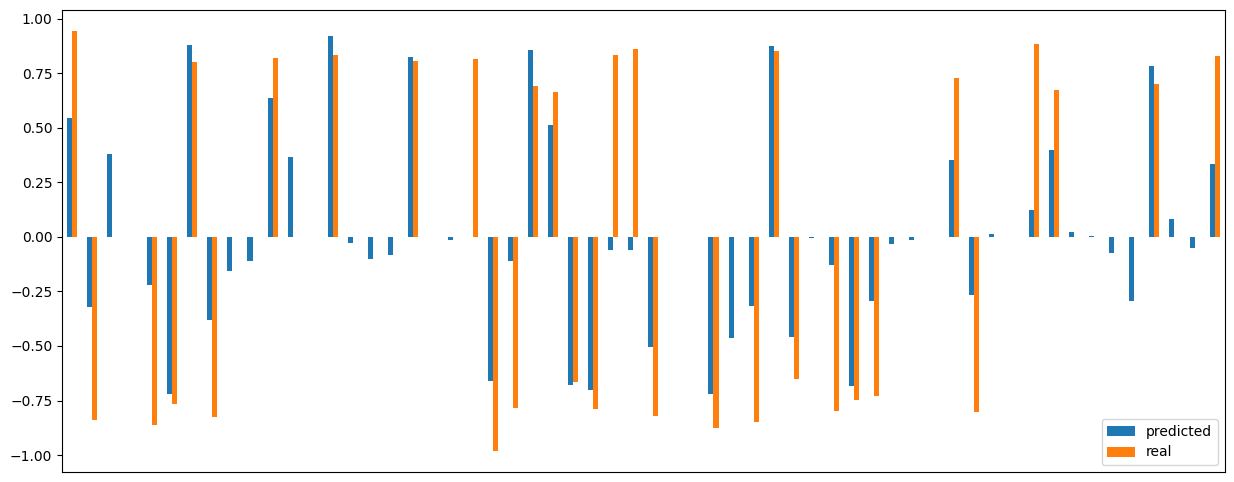

In [127]:
# Confidence prediction efficency
analysis_df = pd.DataFrame({
    'predicted': y_pred,
    'real': y_test
})
analysis_df.plot(kind='bar', figsize=(15, 6), xticks=[])

## Metrics

In [128]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
("MAE:", mae, "MSE:", mse, "R2:", r2)

('MAE:',
 0.23583236206896555,
 'MSE:',
 0.1222816221955,
 'R2:',
 0.6554923481604129)

In [129]:
def assign_class(value):
    if value >= -1 and value <= -neutral_limit:
        return 'Negative'
    elif value > -neutral_limit and value < neutral_limit:
        return 'Neutral / author is just sharing information'
    elif value >= neutral_limit and value <= 1:
        return 'Positive'

# Apply the function to assign classes based on the regression result
analysis_df['predicted_class'] = analysis_df['predicted'].apply(assign_class)
analysis_df['real_class'] = analysis_df['real'].apply(assign_class)

"Accuracy", accuracy_score(analysis_df['real_class'], analysis_df['predicted_class'])


('Accuracy', 0.8448275862068966)

## Custom inputs

In [167]:
custom_input = "The weather is nice"
assessor = Assessor()
assessor.assess_sentiment(model, preprocessor, vectorizer, custom_input)

INPUT: The weather is nice PREDICTION: 0.8080619999999997


0.8080619999999997